In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import shap

In [41]:
df_train_minmax = pd.HDFStore("../../cloudcontainer/concatenated_experiments.hdf5", mode='r').select("alldata_mean_instead_of_NaN/train/minmax")
df_val_minmax = pd.HDFStore("../../cloudcontainer/concatenated_experiments.hdf5", mode='r').select("alldata_mean_instead_of_NaN/val/minmax")
df_test_minmax = pd.HDFStore("../../cloudcontainer/concatenated_experiments.hdf5", mode='r').select("alldata_mean_instead_of_NaN/test/minmax")

df_pressure_train_minmax = df_train_minmax["pressure"]
df_pressure_val_minmax = df_val_minmax["pressure"]
df_pressure_test_minmax = df_test_minmax["pressure"]

df_ae_train_minmax = df_train_minmax["ae"]
df_ae_val_minmax = df_val_minmax["ae"]
df_ae_test_minmax = df_test_minmax["ae"]


df_train_minmax = df_train_minmax.drop(["pressure"], axis=1)
df_val_minmax = df_val_minmax.drop(["pressure"], axis=1)
df_test_minmax = df_test_minmax.drop(["pressure"], axis=1)

'''
df_train_minmax = df_train_minmax.drop(["ae"], axis=1)
df_val_minmax = df_val_minmax.drop(["ae"], axis=1)
df_test_minmax = df_test_minmax.drop(["ae"], axis=1)
'''

np_train_minmax = df_train_minmax.to_numpy()
np_val_minmax = df_val_minmax.to_numpy()
np_test_minmax = df_test_minmax.to_numpy()
np_pressure_train_minmax = df_pressure_train_minmax.to_numpy()
np_pressure_val_minmax = df_pressure_val_minmax.to_numpy()
np_pressure_test_minmax = df_pressure_test_minmax.to_numpy()
np_ae_train_minmax = df_ae_train_minmax.to_numpy()
np_ae_val_minmax = df_ae_val_minmax.to_numpy()
np_ae_test_minmax = df_ae_test_minmax.to_numpy()


In [42]:
train_len = len(df_train_minmax)
val_len = len(df_val_minmax)

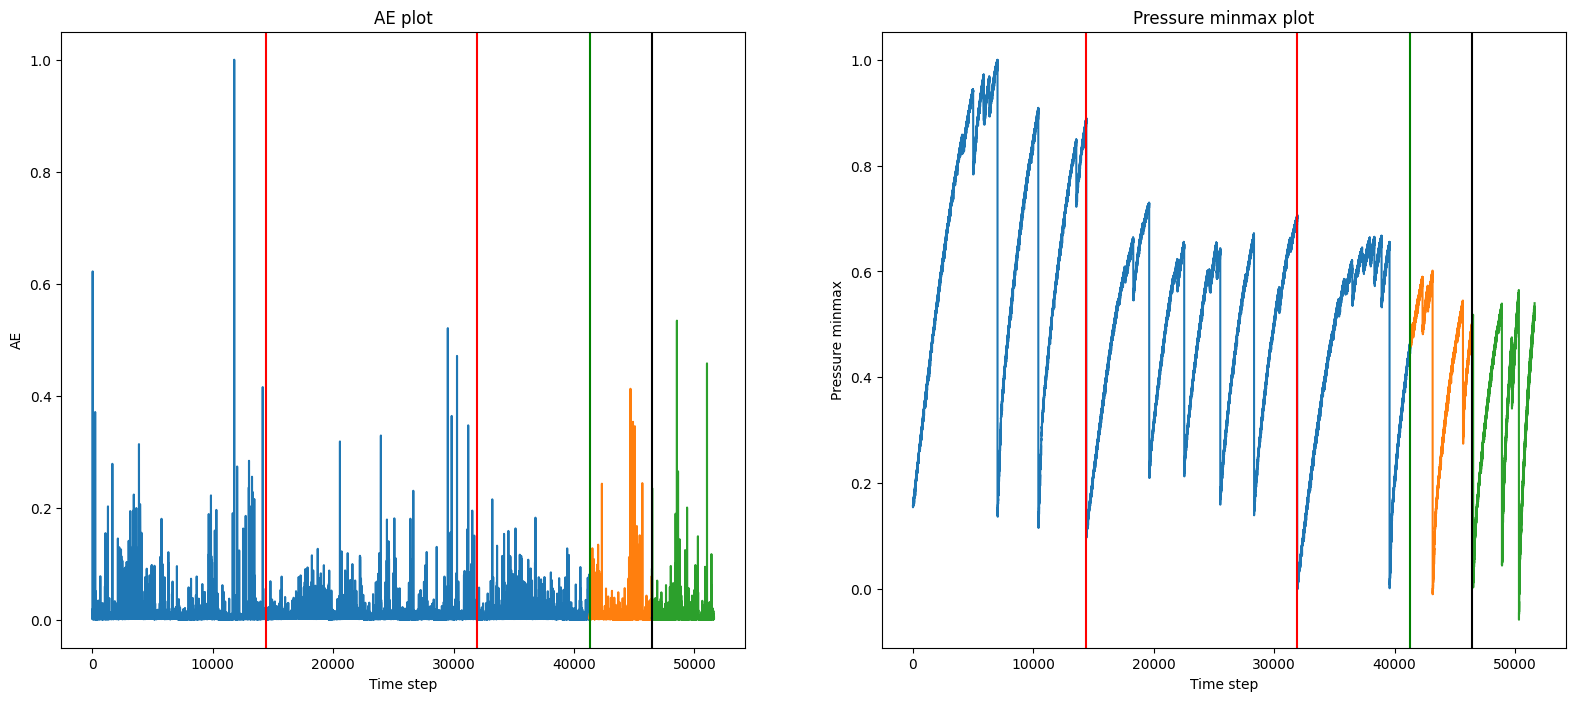

In [43]:
fig = plt.figure(figsize=(30,8))
ax1 = fig.add_subplot(131)
plt.plot(df_ae_train_minmax)
plt.plot(df_ae_val_minmax)
plt.plot(df_ae_test_minmax)
plt.title("AE plot")
plt.ylabel('AE')
plt.xlabel('Time step')
plt.axvline(x=14400, color='r')
plt.axvline(x=14400+17515, color='r')
plt.axvline(x=train_len, color='g')
plt.axvline(x=train_len+val_len, color='black')

ax2 = fig.add_subplot(132)
plt.plot(df_pressure_train_minmax)
plt.plot(df_pressure_val_minmax)
plt.plot(df_pressure_test_minmax)
plt.title("Pressure minmax plot")
plt.ylabel('Pressure minmax')
plt.xlabel('Time step')
plt.axvline(x=14400, color='r')
plt.axvline(x=14400+17515, color='r')
plt.axvline(x=train_len, color='g')
plt.axvline(x=train_len+val_len, color='black')

train mse:  0.00961383039020592
val mse:  0.012932311746358035
test mse:  0.026833441346417426
Parameters of the trained model:  {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': 'deprecated', 'positive': False}


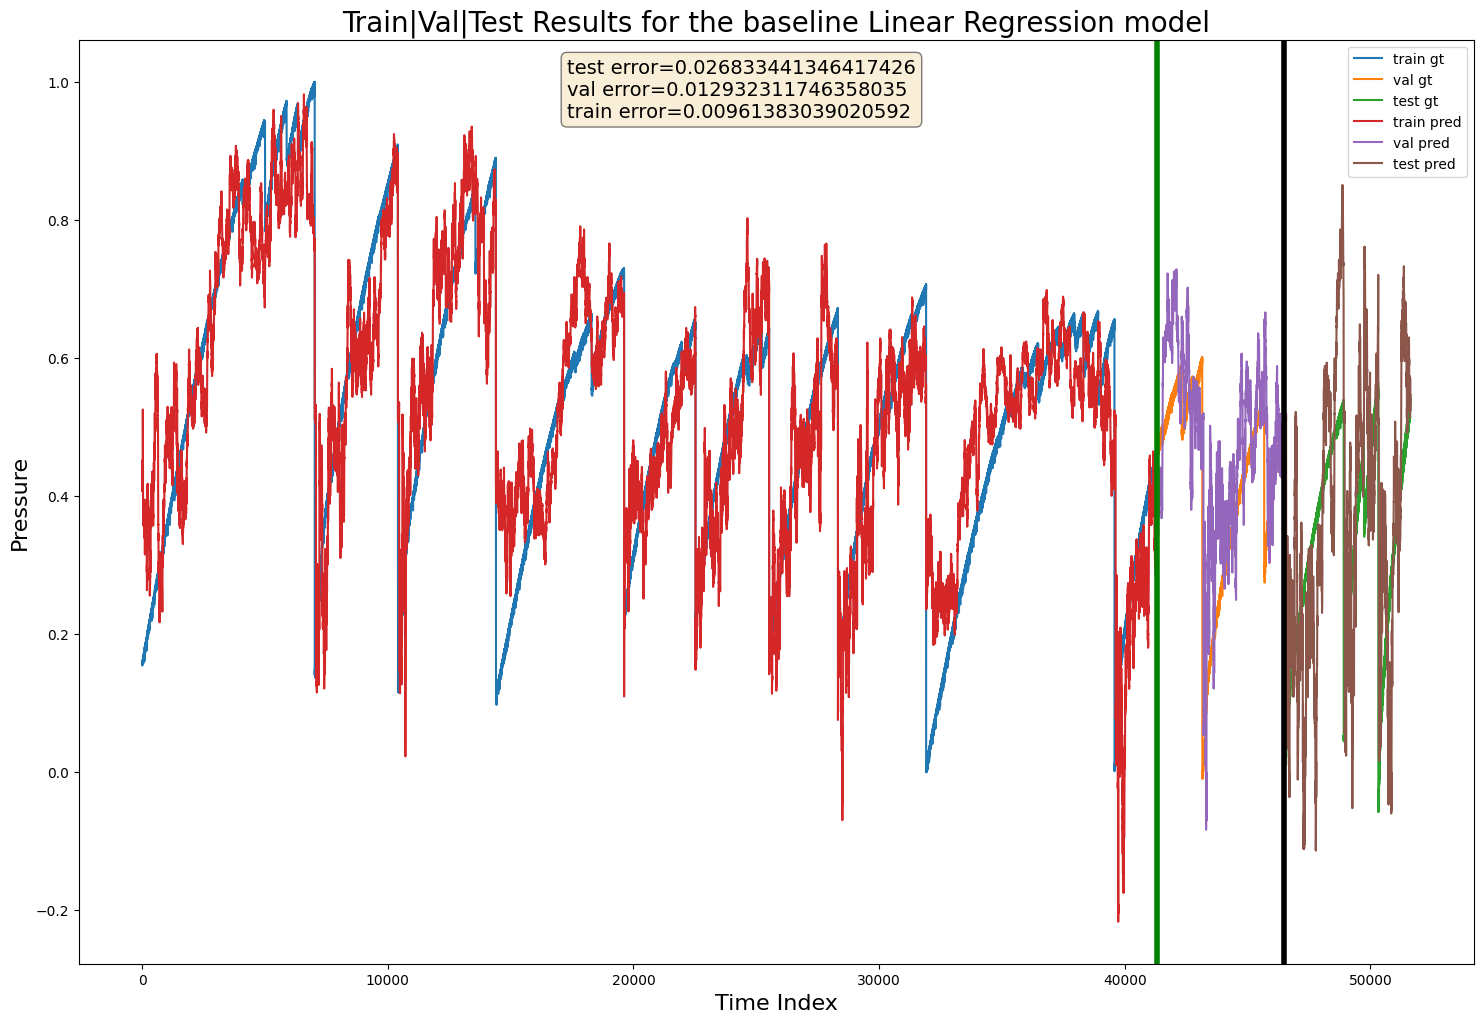

In [44]:
baseline_linear_regression_seismology_model = LinearRegression().fit(np_train_minmax, np_pressure_train_minmax) 
# Note that I use the default tol (tolerance) parameter here. 

np_predictions_train = baseline_linear_regression_seismology_model.predict(np_train_minmax)
df_predictions_train = pd.DataFrame(np_predictions_train)

np_predictions_val = baseline_linear_regression_seismology_model.predict(np_val_minmax)
df_predictions_val = pd.DataFrame(np_predictions_val, index=[i for i in range(len(np_train_minmax), len(np_train_minmax)+len(np_predictions_val))])

np_predictions_test = baseline_linear_regression_seismology_model.predict(np_test_minmax)
df_predictions_test = pd.DataFrame(np_predictions_test, index=[i for i in range(len(np_train_minmax)+len(np_predictions_val), len(np_train_minmax)+len(np_predictions_val)+len(np_predictions_test))])

# Use sklearn MSE metrics to compare with the deep learning model
# using the same exact implementation of the metric:
mse_train = metrics.mean_squared_error(np_pressure_train_minmax, np_predictions_train)
mse_val = metrics.mean_squared_error(np_pressure_val_minmax, np_predictions_val)
mse_test = metrics.mean_squared_error(np_pressure_test_minmax, np_predictions_test)
print("train mse: ", mse_train)
print("val mse: ", mse_val)
print("test mse: ", mse_test)
best_model_parameters = baseline_linear_regression_seismology_model.get_params()
print("Parameters of the trained model: ", best_model_parameters)

fig, ax = plt.subplots(figsize=(18,12))
ax.plot(df_pressure_train_minmax, label="train gt")
ax.plot(df_pressure_val_minmax, label="val gt")
ax.plot(df_pressure_test_minmax, label="test gt")

ax.plot(df_predictions_train, label="train pred")
ax.plot(df_predictions_val, label="val pred")
ax.plot(df_predictions_test, label="test pred")

ax.axvline(x=train_len, color='g', lw=4)
ax.axvline(x=train_len+val_len, color='black', lw=4)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
text_box_str = f"test error={mse_test}" + f"\nval error={mse_val}" + f"\ntrain error={mse_train}"
ax.text(0.35, 0.98, text_box_str, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)

ax.set_title(f"Train|Val|Test Results for the baseline Linear Regression model", fontsize=20)
ax.set_xlabel("Time Index", fontsize=16)
ax.set_ylabel("Pressure", fontsize=16)
plt.legend()
plt.savefig(f"../../cloudcontainer/experiments_related/linearregressionmodel_with_degree1features.png")

In [45]:
# Info about masker: 
# https://stackoverflow.com/questions/66560839/what-do-maskers-really-do-in-shap-package-and-fit-them-to-train-or-test
masker = shap.maskers.Independent(data=df_train_minmax)
explainer = shap.LinearExplainer(baseline_linear_regression_seismology_model, masker=masker)

shap_values = explainer(df_test_minmax)
global_shap_values = np.mean(shap_values.values, axis=0) # this will average the shap values over all the test samples.
print("global shap values shape: ", global_shap_values.shape)
print("global shap values: ", global_shap_values)

global shap values shape:  (49,)
global shap values:  [ 2.87783339e-05  2.75733506e-03  3.05177118e-03  2.75272721e-02
  2.00415944e-03 -2.90097670e-03  1.06717741e-02 -3.29836203e-02
 -6.95989197e-02  6.07562876e-04 -1.00802412e-02 -2.21743731e-03
  5.39027216e-03 -7.27249650e-04 -1.00048792e-02  1.55144866e-02
 -2.74661920e-03  5.21005143e-05  9.18402741e-04  2.51842313e-02
 -1.91071328e-04 -3.35595619e-03  8.75756354e-02 -1.36282138e-01
 -3.35144020e-02 -2.12721055e-02 -3.79428776e-03 -1.95174197e-02
 -5.66420445e-01  2.29445984e-01  4.84437518e-01 -9.03830457e-03
 -5.84146039e-02 -6.04762284e-02  7.97096213e-03 -1.31004176e-02
  2.70152609e-02  3.44153885e-03  2.18369025e-02  8.35026368e-03
 -1.83278667e-02  9.02122230e-03 -3.12680430e-03  3.47315402e-02
 -8.29767737e-03 -4.91831756e-02 -1.33785616e-02 -1.02771663e-02
 -3.24731557e-02]


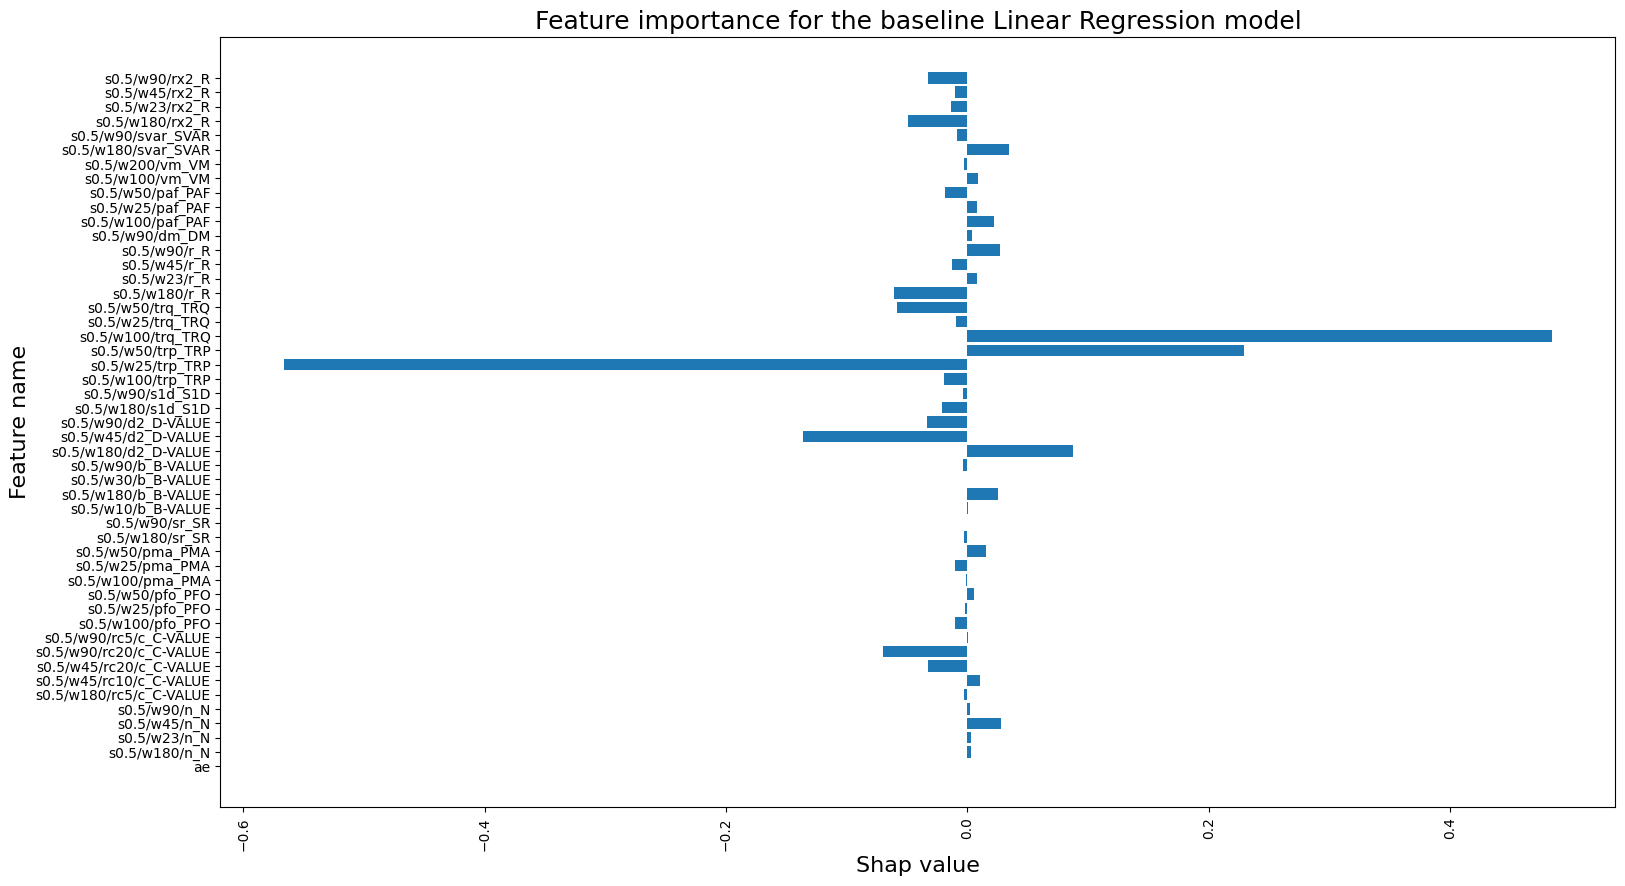

In [46]:
features = df_test_minmax.columns
plt.figure(figsize=(18, 10))
plt.barh(features, global_shap_values)
plt.xticks(rotation="vertical")
plt.title("Feature importance for the baseline Linear Regression model", fontsize=18)
plt.ylabel("Feature name", fontsize=16)
plt.xlabel("Shap value", fontsize=16)
plt.savefig(f"../../cloudcontainer/experiments_related/linearregressionmodel_feature_importance.png")